# Streaming

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [22]:
from langchain_openai import ChatOpenAI
from pprint import pprint
model = ChatOpenAI(model = "gpt-4o", temperature=0)

In [36]:
from langchain_core.messages import AnyMessage,BaseMessage
from pydantic import BaseModel, Field
from typing import List,Sequence, Annotated,Optional
from langgraph.graph.message import add_messages
class State(BaseModel):
    messages:  Annotated[List[AnyMessage], add_messages]= Field(description="List of messages between agent and user")
    summary: Optional[str] = Field(None,description="Summary of the message history so far")

In [37]:
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
# define logic o call model
def call_model(state:State):
    state_dict= state.model_dump()
    summary = state_dict.get("summary", "")
    if summary:
        
        # add summary to the system message
        system_message = f"Summary of the conversation earlier: {summary}"
        
        # append summary to newer messages
        messages = [SystemMessage(content=system_message)] + state_dict["messages"]
    else:
        messages = state_dict["messages"]
    
    response = model.invoke(messages)
    return {"messages":response}        
    
    

In [38]:
# message summary node
def summarize_conversation(state: State):
    state_dict = state.model_dump()
    summary = state_dict.get("summary", "")
    
    if summary:
        summary_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"
    
    # add prompt to our history
    messages = state_dict["messages"] + [HumanMessage(content = summary_message)]
    response = model.invoke(messages)
    print(f"in summary node: {response}")
    
    # delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m["id"]) for m in state_dict["messages"][:-2]]
    return {"summary": response.content, "messages":delete_messages}
    

In [39]:
from langgraph.graph import END
def should_continue(state:State):
    """ 
    Return to the next node to execute

    Args:
        state (State): Current state of the graph
    """
    messages = state.model_dump()["messages"]
    if len(messages)>6: # summarize conversaiton if we have >6 messages
        return "summarize_conversation"
    
    # otherwise we can just end it
    return END

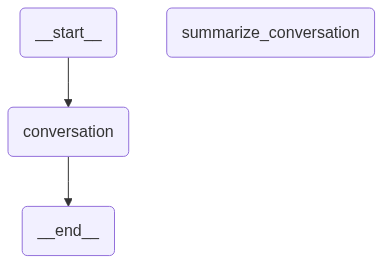

In [40]:
# Building graph with MemorySaver checkpointer
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# build graph
workflow = StateGraph(State)
# add nodes
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)
# add edges
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)
# add memory
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
#display
display(Image(graph.get_graph().draw_mermaid_png()))

# Streaming the full state
- Can stream in 2 ways: .stream: synchronous streaming, .astream: asynchrounous
- .values: Streams the full state of the graph after each node is called
- .updates: Streams updates to the state of the graph after each node is called

In [42]:
# Example 1: Streaming using .updates
config = {"configurable": {"thread_id":1}}

# start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I am John Doe")]}, config, stream_mode="updates"):
    chunk['conversation']['messages'].pretty_print()

================================== Ai Message ==================================

Hello again, John Doe! How can I help you today?


In [43]:
# Example 1: Streaming using .values
# this streams the full state of the graph
config = {"configurable": {"thread_id":2}}

# start conversation
for event in graph.stream({"messages": [HumanMessage(content="hi! I am John Doe")]}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()

================================ Human Message =================================

hi! I am John Doe
================================ Human Message =================================

hi! I am John Doe
================================== Ai Message ==================================

Hello, John Doe! How can I assist you today?


# Streaming tokens
- Often we want to stream more than just state
- When LLMs are used, its comon to stream the tokens as they are generated
- Can use .astream_events method which streams back events as they happen inside nodes
- Each event is a dict with a few keys:
    - event: The type of event being emitted
    - name: Name of the event
    - data: The data associated with event
    - metadata: Which contains langgraph_node, the node emitting the event

In [44]:
config = {"configurable": {"thread_id":5}}
input_message = HumanMessage(content="Tell me about 49ers NFL team!")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node', '')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

Here we can see **on_chat_model_stream** events are the ones where we interact with OpenAI model
- We can see individual tokesn inside chunks in event['data']

In [ ]:
# checks
node_to_stream = 'conversation'
config = {"configurable": {"thread_id":"111"}}
input_message = HumanMessage(content= "Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages":[input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '')==node_to_stream:
        data = event['data']
        print(data['chunk'].content, end = '|') # visualizing each individual generated tokens

|The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area|.| They| are| part| of| the| National| Football| League| (|NFL|)| and| compete| in| the| National| Football| Conference| (|N|FC|)| West| division|.| The| team| was| established| in| |194|6| as| a| charter| member| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| and| joined| the| NFL| in| |194|9| when| the| leagues| merged|.

|###| Key| As|pects| of| the| |49|ers|:

|-| **|Team| Name| and| Colors|**|:| The| name| "|49|ers|"| refers| to| the| prospect|ors| who| arrived| in| Northern| California| during| the| |184|9| Gold| Rush|.| The| team's| colors| are| red|,| gold|,| and| white|.

|-| **|St|adium|**|:| The| |49|ers| play| their| home| games| at| Levi|'s| Stadium| in| Santa| Clara|,| California|,| which| they| have| called| home| since| |201|4|.| Prior| to| that|,| they| played| at| Cand|lestick| Park| in| San| Francisco|.

|-| **|Champ|ionship|s| and| Ach|i

In [47]:
from langgraph_sdk import get_client
URL = "http://127.0.0.1:2024" # URL of current langgraph studio run
client = get_client(url = URL)

# search all hosted graphs
assistants = await client.assistants.search()
assistants

[{'assistant_id': 'aeeca555-f5bc-54f4-b938-621c039f88ae',
  'graph_id': 'openai_agent',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'openai_agent',
  'created_at': '2025-08-23T21:31:40.740708+00:00',
  'updated_at': '2025-08-23T21:31:40.740708+00:00',
  'version': 1,
  'description': None}]

In [51]:
# use this client now
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content = "Multiply 3 by 7")

async for event in client.runs.stream(thread["thread_id"], assistant_id="aeeca555-f5bc-54f4-b938-621c039f88ae", input= {"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get("messages", None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 3 by 7' additional_kwargs={} response_metadata={} id='8eedf110-f0e4-4953-a04e-ce9196795379'
content='3 multiplied by 7 equals 21.' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 13, 'output_tokens': 9, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 13, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-C7qHFWdl5MBCXaWqmkzrlRDCKk0sf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--f225d110-375a-48d0-8d1a-93a72bdcb1a8-0'


Langgraph provides another mode called 'messages' when working with API
- messages/partial: Tokens generated from LLMs
- messages/complete: Fully formed message
- metadata: metadata about run

In [53]:
thread = await client.threads.create()
input_message = HumanMessage(content = "Tell me knock knock joke")

async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="aeeca555-f5bc-54f4-b938-621c039f88ae",
                                      input= {"messages": [input_message]},
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


## Formatting streamed messages when we get tokens from inputs
- We write custom formatting for when agent uses tool call, streams metadata and tokens

In [55]:
thread = await client.threads.create()
input_message = HumanMessage(content = "WHat is capital of Argentina?")

def format_tool_calls(tool_calls):
    if tool_calls:
        formatted_tool_calls = []
        for call in tool_calls:
            formatted_tool_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_tool_calls)
    return "No tool calls"

async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="aeeca555-f5bc-54f4-b938-621c039f88ae", 
                                      input= {"messages": [input_message]}, 
                                      stream_mode="messages"):
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-"*50)
    elif event.event == "messages/partial":
        for data_item in event.data:
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})
                
                if content:
                    print(f"AI: {content}")
                
                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))
                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))
                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
        print("-"*50)

Metadata: Run ID - 0198d8ee-6673-706e-ab4e-105e6581e83b
--------------------------------------------------
--------------------------------------------------
AI: The
--------------------------------------------------
AI: The capital
--------------------------------------------------
AI: The capital of
--------------------------------------------------
AI: The capital of Argentina
--------------------------------------------------
AI: The capital of Argentina is
--------------------------------------------------
AI: The capital of Argentina is Buenos
--------------------------------------------------
AI: The capital of Argentina is Buenos Aires
--------------------------------------------------
AI: The capital of Argentina is Buenos Aires.
--------------------------------------------------
AI: The capital of Argentina is Buenos Aires.
Response Metadata: Finish Reason - stop
--------------------------------------------------


# Breakpoints
- Adding breakpoints for Human in loop
- Can do:
    - Approval: Interrupting agent, surfacing state to user and allow user to accept an action
    - Debugging: Rewind graph state to reproduce or avoid issues
    - Editing: MOdify graph state
- langgraph breakpoints provide a simple way to stop the graph at specific steps


## Breakpoints for Human Approval 
- e.g. We want the agent to ask a human before using any tools
- Execution will be interrupted right before the node tools
- all we need to do is use compile the graph with interrupt_before = ['tools'] where tools is out tool node

In [57]:
from langchain_openai import ChatOpenAI
from typing import Union

# define tools

def multiply_numbers(a:int, b:int)->int:
    """_summary_

    Args:
        a (int): First number
        b (int): Second number

    Returns:
        int: Product of a and b
    """
    return a*b

def divide_numbers(a:int, b:int)->Union[float, None]:
    """_summary_

    Args:
        a (int): First number
        b (int): Second number

    Returns:
        Union[float, None]: Quotient of a and b
    """
    return a/b if b != 0 else None

def add_numbers(a:int, b:int)->int:
    """_summary_

    Args:
        a (int): First number
        b (int): Second number

    Returns:
        int: Sum of a and b
    """
    return a+b

def subtract_numbers(a:int, b:int):
    """_summary_

    Args:
        a (int): First number
        b (int): Second number

    Returns:
        int: Difference of a and b
    """
    return a-b
tools = [multiply_numbers, divide_numbers, add_numbers, subtract_numbers]

In [58]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)
llm_with_tools = llm.bind_tools(tools)

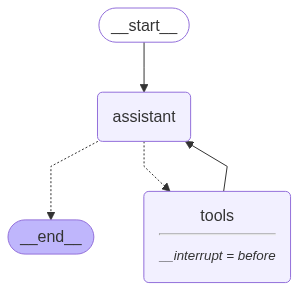

In [59]:
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from pydantic import BaseModel, Field
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import START, StateGraph, END
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

class MessagesState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages] = Field(default_factory=list)


system_message = SystemMessage(content="You are a helpful assistnat tasked with performing arithmetic on a set of inputs.")

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([system_message] + state.model_dump()['messages'])]}


# builder
builder = StateGraph(MessagesState)
# add nodes
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))
# add edges
builder.add_edge(START,'assistant')
builder.add_conditional_edges(
    'assistant',
    tools_condition
)
builder.add_edge('tools', 'assistant')
#compile graph
react_graph = builder.compile(interrupt_before = ['tools'], checkpointer = memory)

# display graph
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [60]:
# check if interrupts when using tool
initial_message = HumanMessage(content="Multiply 3 by 7")

thread = {"configurable": {"thread_id": "1"}}

# run the graph untill the first interruption
for event in react_graph.stream({"messages": [initial_message]}, thread, stream_mode = "values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 3 by 7
================================== Ai Message ==================================
Tool Calls:
  multiply_numbers (call_nyiMs7ee0kVJKpSHUcwpnuUP)
 Call ID: call_nyiMs7ee0kVJKpSHUcwpnuUP
  Args:
    a: 3
    b: 7


In [ ]:
# looking at the state of the graph that was interrupted
state = react_graph.get_state(thread)
state.next # next node to be executed is 'tools'

('tools',)

react_graph.get_state(thread) gets the StateSnapshot() of the current state
- When we invoke the graph with None, it will just continue from the last state checkpoint

In [62]:
for event in react_graph.stream(None, thread, stream_mode = "values"):
    event['messages'][-1].pretty_print() # this will call tool Node now

================================== Ai Message ==================================
Tool Calls:
  multiply_numbers (call_nyiMs7ee0kVJKpSHUcwpnuUP)
 Call ID: call_nyiMs7ee0kVJKpSHUcwpnuUP
  Args:
    a: 3
    b: 7
================================= Tool Message =================================
Name: multiply_numbers

21
================================== Ai Message ==================================

The result of multiplying 3 by 7 is 21.


In [ ]:
# Putting it all together

initial_message = HumanMessage(content="Multiply 3 by 7")

thread = {"configurable": {"thread_id": "1"}}

for event in react_graph.stream({"messages": [initial_message]}, thread, stream_mode = "values"):
    event['messages'][-1].pretty_print() # this will call tool Node now

user_approval = input("Do you approve of the tool call? (y/n)")

if user_approval == "y":
    for event in react_graph.stream(None, thread, stream_mode = "values"):
        event['messages'][-1].pretty_print()
else:
    print("Tool call not approved")

================================ Human Message =================================

Multiply 3 by 7


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_p2YMMLbM5uFJYP8U88K9hqmT", 'type': 'invalid_request_error', 'param': 'messages.[11].role', 'code': None}}